In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils.utilities import *
from utils.loss_func import *
from utils.models import *
import tensorflow as tf
from PIL import Image
import numpy as np
import scipy.io
import sys
import cv2
import os

#### Read vgg19 weights

In [2]:
vgg_weights = scipy.io.loadmat('imagenet-vgg-verydeep-19.mat')
# print(vgg_weights.keys())
vgg_layers = vgg_weights['layers'][0]

#### Set Params

In [3]:
content_layers = ['h_conv4_2']
style_layers = ['h_relu1_1', 'h_relu2_1', 'h_relu3_1', 'h_relu4_1', 'h_relu5_1']
style_weight = [.2, .2, .2, .2, .2]

alpha = 5e0
beta = 1e2
theta = 1e-2

iter_num = 1000
learning_rate = 1e0

#### Preprocess Inputs

In [4]:
avg_values = np.array([123.68, 116.779, 103.939]).reshape(1,1,1,3)

#### Main Operation

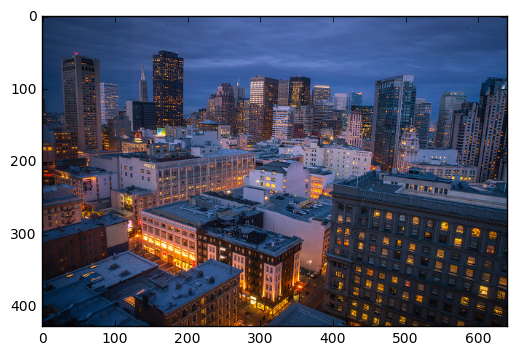

In [5]:
plt.imshow(base_content)

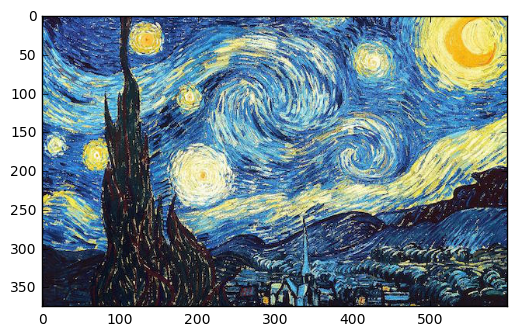

In [8]:
plt.imshow(base_style)

In [5]:
# read content and style image
base_content = read_img('base1.jpg')
base_style = read_img('style3.jpg')
# base_style = cvt2original_color(base_content, base_style)

# resize style img
base_style = resize_style(base_content, base_style)

# zero-center the image value to fit into vgg net
base_content = pre_process(base_content)
base_style = pre_process(base_style)

Resized... content image size: 427, 640 / style image size: 427, 640


In [6]:
# Initialize the model
tf.reset_default_graph()
vgg_style = load_model(base_content)
sess = tf.InteractiveSession(config=tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=True))

# build content loss in the graph
con_loss = wrap_content_loss(sess, vgg_style, base_content)

# build style loss in the graph
st_loss = wrap_style_loss(sess, vgg_style, base_style)

# build noise loss in the graph
noise_loss = tf.image.total_variation(vgg_style['input'])
# noise_loss = de_noise(vgg_style['input'])

total_loss = alpha * con_loss + \
             beta * st_loss + \
             theta * noise_loss
"""
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(total_loss)
"""
optimizer = tf.contrib.opt.ScipyOptimizerInterface(
      total_loss, method='L-BFGS-B',
      options={'maxiter': iter_num,
                  'disp': 50})

In [32]:
%%time
sess.run(tf.global_variables_initializer())
optimizer.minimize(sess)
print('optimization finished')
out = vgg_style['input'].eval()
out = post_process(out)
sess.close()
del vgg_style
print('session closed')

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 4615715.000000
  Number of iterations: 1001
  Number of functions evaluations: 1011
optimization finished
session closed
Wall time: 8min 24s


#### alpha = 5e0 / beta = 1e2 / theta = 1e-2

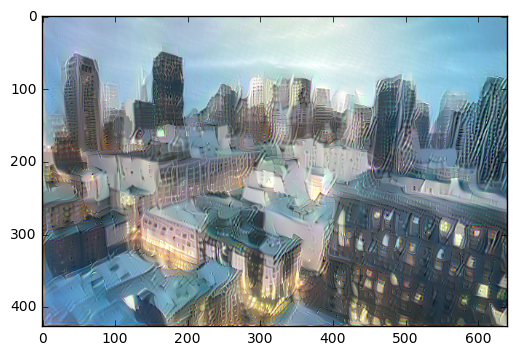

In [33]:
plt.imshow(out)
plt.show()

#### alpha = 5e0 / beta = 1e2 / theta = 1e-3

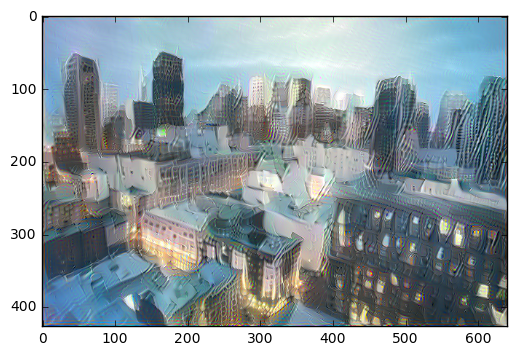

In [25]:
plt.imshow(out)
plt.show()

#### alpha = 5e0 / beta = 1e4 / theta = 1e-3

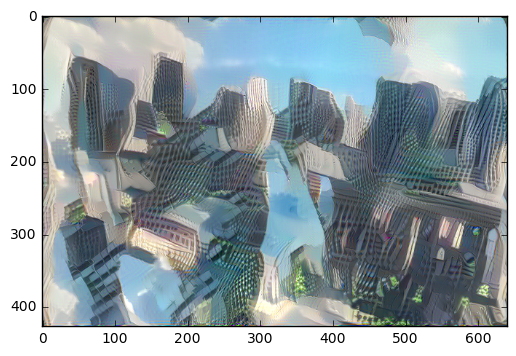

In [20]:
plt.imshow(out)
plt.show()

#### alpha = 5e0 / beta = 1e3 / theta = 1e-3

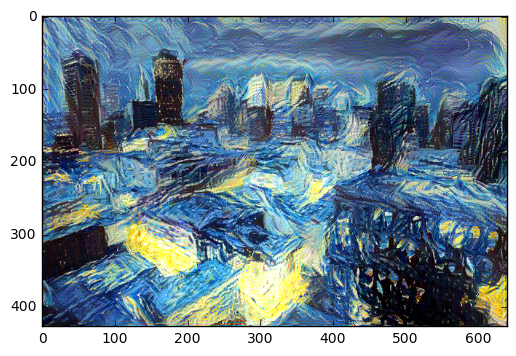

In [15]:
plt.imshow(out)
plt.show()

#### alpha = 5e0 / beta = 1e4 / theta = 1e-3

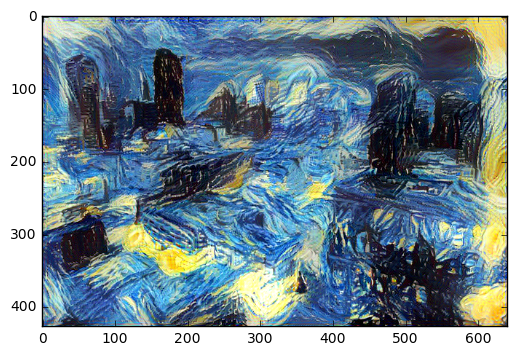

In [142]:
out = vgg_style['input'].eval()
out = post_process(out)
plt.imshow(out)
plt.show()

#### alpha = 5e0 / beta = 1e5 / theta = 1e-3

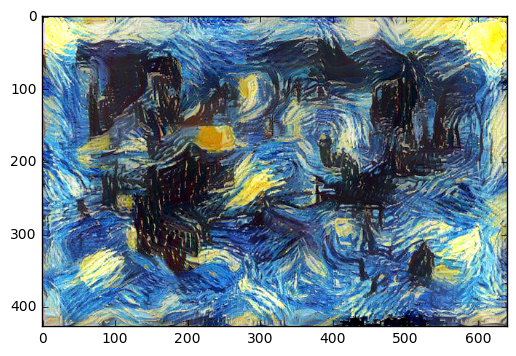

In [138]:
out = vgg_style['input'].eval()
out = post_process(out)
plt.imshow(out)
plt.show()

#### Loss Calculation

In [7]:
def content_loss(gen, base, mode=0):
    """
        Define the content loss for the image
    """
    _, h, w, f = gen.get_shape()
    M = h.value * w.value
    N = f.value
    if mode == 0:
        params = 1. / (2. * N**0.5 * M**0.5)
    if mode == 1:
        _, h, w, f = gen.get_shape()
        params = 1. / (h * w)
    if mode == 2:
        params = 1. / 2.
    loss = params * tf.reduce_sum(tf.pow((gen - base), 2))
    return loss

def style_loss(gen, base, mode=0):
    """
        Define the style loss for the image
    """
    _, h, w, f = gen.get_shape()
    M = h.value * w.value
    N = f.value
    if mode == 0:
        gram_gen = gram_matrix(gen)
        gram_base = gram_matrix(base)
        loss_scale = 1. / (4 * M**2 * N**2)
        loss = loss_scale * tf.reduce_sum(tf.pow((gram_gen - gram_base), 2))
    if mode == 1:
        avg_gen = avg_flat(gen)
        avg_base = avg_flat(base)
        loss_scale = 1. / (4 * M**2 * N**2)
        loss = loss_scale * tf.reduce_sum(tf.pow((avg_gen - avg_base), 2))
    return loss

def de_noise(gen):
    loss = tf.reduce_sum(tf.abs(gen[:,1:,:,:] - gen[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(gen[:,:,1:,:] - gen[:,:,:-1,:]))
    return loss

def wrap_content_loss(sess, vggnet, content_img):
    """
        Accumulate all content loss from suggested layers
    """
    base = sess.run(vggnet['input'].assign(content_img))
    loss = 0.
    for lay in content_layers:
        base_layer = sess.run(vggnet[lay])
        base_layer = tf.convert_to_tensor(base_layer)
        # print(base_layer.eval())
        gen_layer = vggnet[lay]
        # print(gen_layer.eval())
        loss += content_loss(gen_layer, base_layer)
    loss /= float(len(content_layers))
    return loss

def wrap_style_loss(sess, vggnet, style_img):
    """
        Accumulate all style loss from suggested layers
    """
    base = sess.run(vggnet['input'].assign(style_img))
    loss = 0.
    for lay, wei in zip(style_layers, style_weight):
        base_layer = sess.run(vggnet[lay])
        base_layer = tf.convert_to_tensor(base_layer)
        gen_layer = vggnet[lay]
        loss += style_loss(gen_layer, base_layer) * wei
    loss /= float(len(style_layers))
    return loss
    
def gram_matrix(tensor):
    num_f = tensor.get_shape().as_list()[-1]
    tensor_flat = tf.reshape(tensor, [-1, num_f])
    gram_out = tf.matmul(tf.transpose(tensor_flat), tensor_flat)
    return gram_out

def avg_flat(tensor):
    # num_f = tensor.get_shape().as_list()[-1]
    tensor_flat = tf.reshape(tensor, [-1])
    return tensor_flat

#### Model Build

In [8]:
def load_model(input_):
    """
        Reconstruct the VGG19 models using weights from pre-trained model
    """
    _, height, width, channel = input_.shape
    vgg_style = {}
    
    vgg_style['input'] = tf.Variable(np.zeros((1, height, width, channel)), dtype=tf.float32)
    
    # restore layer 1
    vgg_style['h_conv1_1'] = conv2d(vgg_style['input'], w=load_weights(vgg_layers, 0), name='h_conv1_1')
    vgg_style['h_relu1_1'] = relu(vgg_style['h_conv1_1'], b=load_biases(vgg_layers, 0), name='h_relu1_1')
    
    vgg_style['h_conv1_2'] = conv2d(vgg_style['h_relu1_1'], w=load_weights(vgg_layers, 2), name='h_conv1_2')
    vgg_style['h_relu1_2'] = relu(vgg_style['h_conv1_2'], b=load_biases(vgg_layers, 2), name='h_relu1_2')
    
    vgg_style['h_pool1'] = pool(vgg_style['h_relu1_2'], name='h_pool1')
    
    # restore layer 2
    vgg_style['h_conv2_1'] = conv2d(vgg_style['h_pool1'], w=load_weights(vgg_layers, 5), name='h_conv2_1')
    vgg_style['h_relu2_1'] = relu(vgg_style['h_conv2_1'], b=load_biases(vgg_layers, 5), name='h_relu2_1')
    
    vgg_style['h_conv2_2'] = conv2d(vgg_style['h_relu2_1'], w=load_weights(vgg_layers, 7), name='h_conv2_2')
    vgg_style['h_relu2_2'] = relu(vgg_style['h_conv2_2'], b=load_biases(vgg_layers, 7), name='h_relu2_2')
    
    vgg_style['h_pool2'] = pool(vgg_style['h_relu2_2'], name='h_pool2')
    
    # restore layer 3
    vgg_style['h_conv3_1'] = conv2d(vgg_style['h_pool2'], w=load_weights(vgg_layers, 10), name='h_conv3_1')
    vgg_style['h_relu3_1'] = relu(vgg_style['h_conv3_1'], b=load_biases(vgg_layers, 10), name='h_relu3_1')
    
    vgg_style['h_conv3_2'] = conv2d(vgg_style['h_relu3_1'], w=load_weights(vgg_layers, 12), name='h_conv3_2')
    vgg_style['h_relu3_2'] = relu(vgg_style['h_conv3_2'], b=load_biases(vgg_layers, 12), name='h_relu3_2')
    
    vgg_style['h_conv3_3'] = conv2d(vgg_style['h_relu3_2'], w=load_weights(vgg_layers, 14), name='h_conv3_3')
    vgg_style['h_relu3_3'] = relu(vgg_style['h_conv3_3'], b=load_biases(vgg_layers, 14), name='h_relu3_3')
    
    vgg_style['h_conv3_4'] = conv2d(vgg_style['h_relu3_3'], w=load_weights(vgg_layers, 16), name='h_conv3_4')
    vgg_style['h_relu3_4'] = relu(vgg_style['h_conv3_4'], b=load_biases(vgg_layers, 16), name='h_relu3_4')
    
    vgg_style['h_pool3'] = pool(vgg_style['h_relu3_2'], name='h_pool3')
    
    # restore layer 4
    vgg_style['h_conv4_1'] = conv2d(vgg_style['h_pool3'], w=load_weights(vgg_layers, 19), name='h_conv4_1')
    vgg_style['h_relu4_1'] = relu(vgg_style['h_conv4_1'], b=load_biases(vgg_layers, 19), name='h_relu4_1')
    
    vgg_style['h_conv4_2'] = conv2d(vgg_style['h_relu4_1'], w=load_weights(vgg_layers, 21), name='h_conv4_2')
    vgg_style['h_relu4_2'] = relu(vgg_style['h_conv4_2'], b=load_biases(vgg_layers, 21), name='h_relu4_2')
    
    vgg_style['h_conv4_3'] = conv2d(vgg_style['h_relu4_2'], w=load_weights(vgg_layers, 23), name='h_conv4_3')
    vgg_style['h_relu4_3'] = relu(vgg_style['h_conv4_3'], b=load_biases(vgg_layers, 23), name='h_relu4_3')
    
    vgg_style['h_conv4_4'] = conv2d(vgg_style['h_relu4_3'], w=load_weights(vgg_layers, 25), name='h_conv4_4')
    vgg_style['h_relu4_4'] = relu(vgg_style['h_conv4_4'], b=load_biases(vgg_layers, 25), name='h_relu4_4')
    
    vgg_style['h_pool4'] = pool(vgg_style['h_relu4_4'], name='h_pool4')
    
    # restore layer 5
    vgg_style['h_conv5_1'] = conv2d(vgg_style['h_pool4'], w=load_weights(vgg_layers, 28), name='h_conv5_1')
    vgg_style['h_relu5_1'] = relu(vgg_style['h_conv5_1'], b=load_biases(vgg_layers, 28), name='h_relu5_1')
    
    vgg_style['h_conv5_2'] = conv2d(vgg_style['h_relu5_1'], w=load_weights(vgg_layers, 30), name='h_conv5_2')
    vgg_style['h_relu5_2'] = relu(vgg_style['h_conv5_2'], b=load_biases(vgg_layers, 30), name='h_relu5_2')
    
    vgg_style['h_conv5_3'] = conv2d(vgg_style['h_relu5_2'], w=load_weights(vgg_layers, 32), name='h_conv5_3')
    vgg_style['h_relu5_3'] = relu(vgg_style['h_conv5_3'], b=load_biases(vgg_layers, 32), name='h_relu5_3')
    
    vgg_style['h_conv5_4'] = conv2d(vgg_style['h_relu5_3'], w=load_weights(vgg_layers, 34), name='h_conv5_4')
    vgg_style['h_relu5_4'] = relu(vgg_style['h_conv5_4'], b=load_biases(vgg_layers, 34), name='h_relu5_4')
    
    vgg_style['h_pool5'] = pool(vgg_style['h_relu5_4'], name='h_pool5')    
        
    return vgg_style

In [9]:
def conv2d(input_, w, name):
    h_conv = tf.nn.conv2d(input_, w, strides=[1,1,1,1], padding='SAME', name=name)    
    return h_conv
    
def relu(input_, b, name):
    b = tf.reshape(b, [-1,])
    # print(b.get_shape())
    h_relu = tf.nn.relu(input_ + b, name=name)
    return h_relu

def pool(input_, name, pool='avg'):
    if pool == 'avg':
        h_pool = tf.nn.avg_pool(input_, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name=name)
    if pool == 'max':
        h_pool = tf.nn.max_pool(input_, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME', name=name)
    return h_pool

In [10]:
def load_weights(layers, idx):
    """
        Loads the layer weight by layer index
    """
    w_ = layers[idx][0][0][2][0][0]
    w = tf.constant(w_)
    return w

def load_biases(layers, idx):
    """
        Loads the layer bias by layer index
    """
    b_ = layers[idx][0][0][2][0][1]
    b = tf.constant(b_)
    return b
